In [1]:
#coding:utf-8
import pandas as pd

In [2]:
import pandas as pd
pd.options.display.max_columns = 200
pd.options.mode.chained_assignment = None

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
from string import punctuation

from collections import Counter
import re
import numpy as np

In [3]:
#读取训练数据
columns = ["name","url","price","vip_price","comment","shop_name","shipping"]
data = pd.read_csv("peijian.csv")
data.columns = columns

In [4]:
data.dtypes

name          object
url           object
price        float64
vip_price     object
comment       object
shop_name     object
shipping      object
dtype: object

In [5]:
print(data.shape)

(118, 7)


In [6]:
data[:2]

,name,url,price,vip_price,comment,shop_name,shipping
0,【818手机节搭配推荐:亿色华为P30Pro无边钻石膜】【专享第2件半价，贴坏包赔！】原配定...,https://item.jd.com/100003940246.html,39.0,￥34.59,5万+,ESR京东自营旗舰店,'自营''放心购''券2880-300''满88-20'
1,【自营精选】华为P30PRO双面玻璃全包防摔保护，万磁王磁吸保护壳》》\n推荐华为P30Pr...,https://item.jd.com/100003961571.html,99.0,￥95.00,1800+,斯泰克（STIGER）京东自营旗舰店,'自营''券2880-300''满88-20'


In [7]:
data.comment = data.comment.str.replace("+","")
comlist = []
for index,item in pd.DataFrame(data).iterrows():
    comment = item["comment"]
    try:
        temp = int(comment)
        comlist.append(temp)
        continue
    except:
        temp = comment.split("万")
        comlist.append(float(temp[0])*10000)

In [8]:
data.comment = pd.DataFrame(comlist)

In [9]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']

In [10]:
comment_menan = data.comment.describe()["mean"]

In [11]:
nicedata = data[data["comment"]>comment_menan]

In [12]:
nicedata.price.describe()

count     29.000000
mean      50.289655
std       50.360716
min       14.900000
25%       29.000000
50%       38.000000
75%       56.000000
max      298.000000
Name: price, dtype: float64

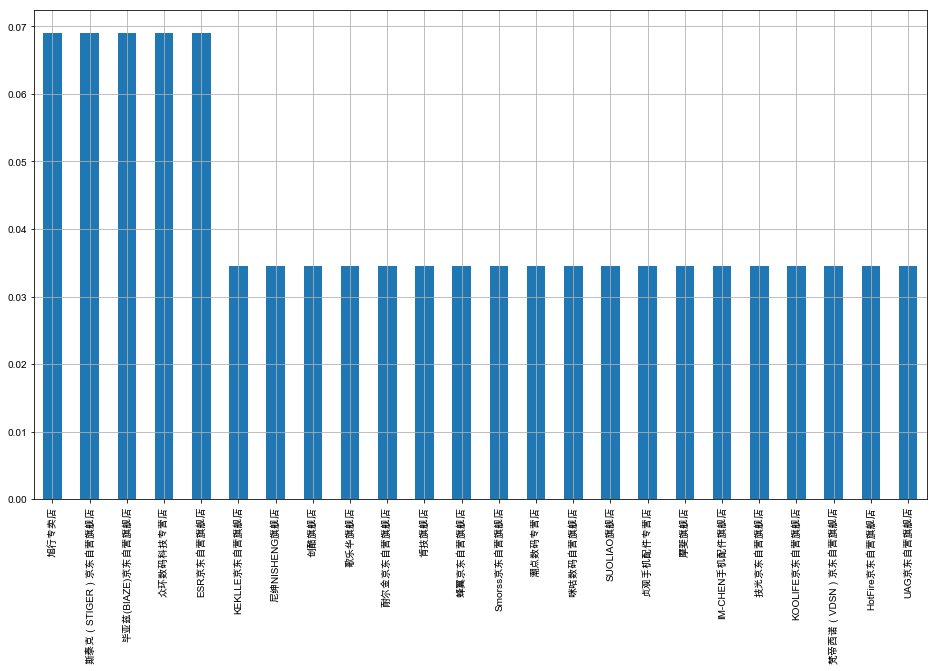

In [13]:
%matplotlib inline
nicedata.shop_name.value_counts(normalize=True).plot(kind='bar', grid=True, figsize=(16, 9))

In [14]:
data = data.drop_duplicates('name')
data = data[~data['name'].isnull()]

print(data.shape)

(68, 7)


In [15]:
data = data[(data.name.map(len) > 5) & (data.name.map(len) <= 300)]
data.reset_index(inplace=True, drop=True)

print(data.shape)

(67, 7)


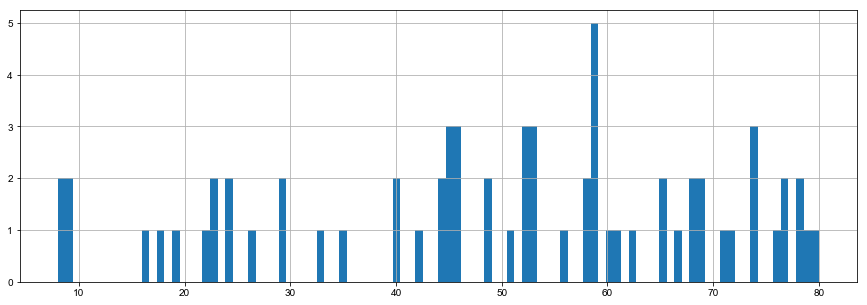

In [16]:
data.name.map(len).hist(figsize=(15, 5), bins=100)

In [17]:
# 创建停用词list
def stopwordslist(filepath):
    stopwords = [line.strip() for line in open(filepath, 'r').readlines()]
    jd_item = ['京东','下单','次日','手机','参加','天无理由','客服','自营','购买','关注','推荐','上述','818','华为','活动']
    jd_item1 = ['限时','活动_','商品','品质','优惠','抢购','真机','型号','全场','点击','保护','优惠']
    jd_item2 = ['保证','天无','理由','全包','包邮','包','同款','配送','图片','正品','保护','优惠']
    jd_item3 = ['更多','店铺','地区','选购','伤机','全包防','专享','免费','系列','正品','保护','优惠']
    stopwords = stopwords + jd_item + jd_item1+jd_item2+jd_item3
    return stopwords

# 对句子进行分词
def seg_sentence(sentence):
    sentence_seged = jieba.cut(sentence)
    stopwords = stopwordslist('./stopwords/百度停用词表.txt')  # 这里加载停用词的路径
    outstr = ''
    
    for word in sentence_seged:
        word = word.strip('\'"?!,.():;？！，。…“”（）：；<>《》/ 、rn【】[]|~#%&*br')
         # 去掉 - &
        word = re.sub(r'(-|\')', '', word)
        word = re.sub(r'(-|\')', '', word)
        if word not in stopwords :
            if word != '\t':
                outstr += word
                outstr += " "
    return outstr

In [18]:
import jieba

In [19]:
# 预处理句子
def preprocess_sentence(sentence, stop_words=False):
    sentence = sentence.lower()
    # 转化URL
    sentence = re.sub(r'((www\.[\S]+)|(https?://[\S]+))', ' URL ', sentence)
    # 去掉空白，单双引号
    sentence = sentence.strip(' "\'')
    # 分词
    words = seg_sentence(sentence)
    # 分别处理每一个单词
    return words
    

In [20]:
seg_sentence("818手机节搭配推荐:亿色华为P30Pro无边钻石膜")

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/vq/w6wkn_bx3ld1sybm0qd0f9t00000gn/T/jieba.cache
Loading model cost 0.681 seconds.
Prefix dict has been built succesfully.


'节 搭配 亿色 P30Pro 无边 钻石 膜 '

In [21]:
exp = data['name'].map(preprocess_sentence)

In [22]:
exp

0     节 搭配 亿色 p30pro 无边 钻石 膜 2 件 半价 贴坏 包赔 原配 定制 全屏 不...
1     精选 p30pro 双面 玻璃 摔 万磁王 磁吸 壳 \n p30pro 全屏 全 覆盖 高...
2     首页 惊喜 防水 袋 2 件 8.5 折 3 件 7.5 折 \n ipx8 级 防水 四层...
3                                          双面 玻璃 智能 触屏 
4     uag818 狂欢 购 满 2 件 8 折 3 件 7 折 好物 满 88 减 20 立享 ...
5     亿色 暑期 价到 折扣 2 件 半价 热销 配件 火热 再 抽奖 赢 限量 百元 优惠券 猛...
6     玻璃 壳 套装 漫威 正版 授权 买复 联手 机壳 送长 挂绳 + 短 挂绳 + 支架 指环...
7     精选 p30pro 智能 休眠 唤醒 智能 视窗 接听 免 翻盖 皮套 \n p30pro ...
8      狂欢 购 爆款 满 88 立减 20 元 热销 配件 火热 中 达 大牌 放心 好货 低价 抢 
9     88 减 20 跨店 满减 领 劵 更 精选 入榜 材料 6 点前 当天 发货 实测 孔位 ...
10    精选 p30pro 抗震 防 摔 指环 壳 360 度 旋转 车载 磁吸 支架 \n p30...
11    快递 时效 达 \n 满 25 减 5 88 减 20 360 ° 摔 软壳 抗 指纹 防爆...
12    今日 满 68 再减 5 元 买三免 买 更 \n 手感 细腻 pp 材质 超薄 磨砂 手感...
13          磨砂 壳 裸机 触感 孔位 精准 壳 膜 搭配 享豪礼 水凝膜 开模 曲面 全 覆盖 
14     达 热销 配件 火热 销售 中 8.2 8.20 满 88 减 20 合并 享 猛 戳 去 不 
15                        p30pro 送水凝膜 p30 送 钢化 膜 现货 速发 
16               轻巧 5000 毫安 电源 日常 售价 69 元 今日 29 元 秒杀 不 
17                 开模 轻薄 柔韧 磨砂 手感 防刮 耐磨 搭配 高 清水 

In [23]:
from wordcloud import WordCloud

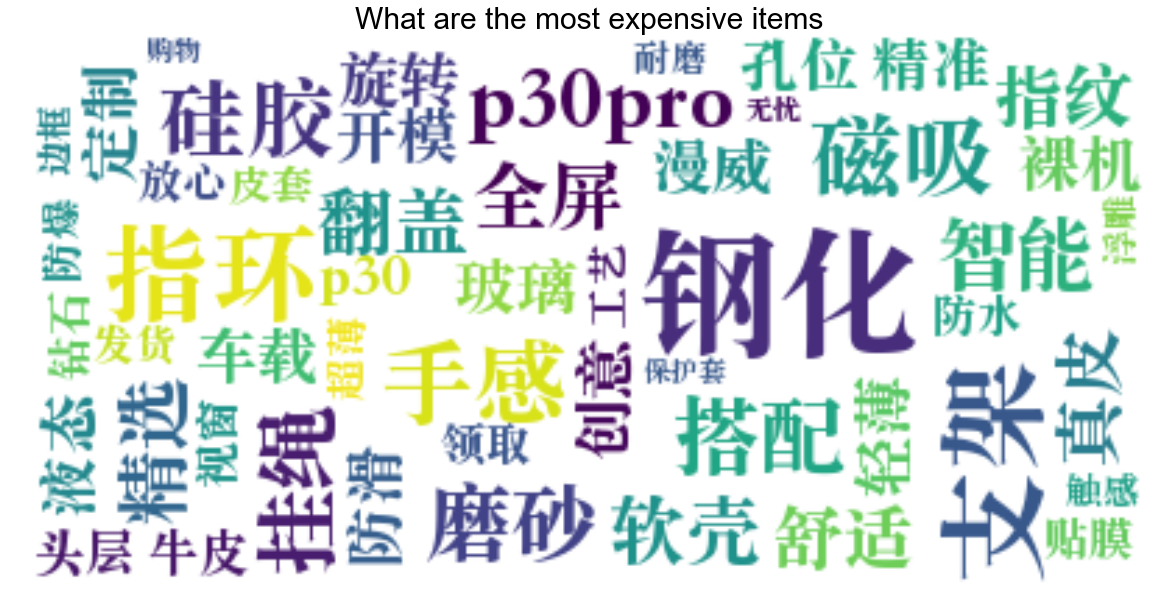

In [24]:


wc = WordCloud(background_color="white", max_words=50, 
                max_font_size= 50,
              font_path="/Library/Fonts/Songti.ttc",)

wc.generate(" ".join(str(s) for s in exp.values))

plt.figure(figsize=(20,12))
plt.title('What are the most expensive items', fontsize = 30)
plt.axis('off')
plt.imshow(wc, interpolation='bilinear')